In [1]:
import glob
import multiprocessing as mp
import os
from pathlib import Path

import cv2
import random
import numpy as np
import PIL
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from sklearn import model_selection, preprocessing
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed()

Random seed set as 42


In [3]:
path = '../input/laba-dataset/samples/'

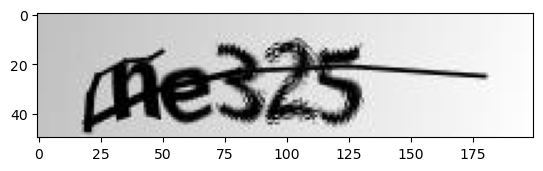

In [4]:
# Load the image and convert it to grayscale
img = cv2.imread(path + 'ne325.png', cv2.IMREAD_GRAYSCALE)

# Display the grayscale image using Matplotlib
plt.imshow(img, cmap='gray')
plt.show()

In [5]:
img = Image.open(path + 'ne325.png').convert('L')

to_tensor = transforms.ToTensor()
img_tensor = to_tensor(img)
# torch.Size([1, 50, 200])

img_tensor.shape

torch.Size([1, 50, 200])

In [6]:
# add another dimension at the front to get NCHW shape
img_tensor = img_tensor.unsqueeze(0)
# torch.Size([1, 1, 50, 200])

img_tensor.shape

torch.Size([1, 1, 50, 200])

In [7]:
assert img_tensor.shape == torch.Size([1, 1, 50, 200])

In [8]:
files = glob.glob(os.path.join(path, "*.png"))
files.extend(glob.glob(os.path.join(path, "*.jpg")))
files[:5]

['../input/laba-dataset/samples/6n6gg.png',
 '../input/laba-dataset/samples/fncnb.png',
 '../input/laba-dataset/samples/nbwnn.png',
 '../input/laba-dataset/samples/ebcbx.png',
 '../input/laba-dataset/samples/nxn4f.png']

In [9]:
captchas = [x.split("/")[-1].split(".")[0] for x in files]
captchas[:5]

['6n6gg', 'fncnb', 'nbwnn', 'ebcbx', 'nxn4f']

In [10]:
captchas[:10]

['6n6gg',
 'fncnb',
 'nbwnn',
 'ebcbx',
 'nxn4f',
 '2en7g',
 'y866y',
 'xcmbp',
 'g247w',
 '56ncx']

In [11]:
len(captchas)

1070

In [12]:
len(set(captchas))

1070

In [13]:
targets_flat = list(''.join(captchas))
char_encoder = dict(zip(set(targets_flat), range(1, len(set(targets_flat)) + 1)))
char_encoder

{'8': 1,
 'p': 2,
 'x': 3,
 'g': 4,
 'e': 5,
 '2': 6,
 'n': 7,
 'c': 8,
 '5': 9,
 'w': 10,
 '4': 11,
 'y': 12,
 '7': 13,
 'm': 14,
 'b': 15,
 'd': 16,
 '3': 17,
 'f': 18,
 '6': 19}

In [14]:
char_encoder_reversed = {v: k for k, v in char_encoder.items()}
char_encoder_reversed

{1: '8',
 2: 'p',
 3: 'x',
 4: 'g',
 5: 'e',
 6: '2',
 7: 'n',
 8: 'c',
 9: '5',
 10: 'w',
 11: '4',
 12: 'y',
 13: '7',
 14: 'm',
 15: 'b',
 16: 'd',
 17: '3',
 18: 'f',
 19: '6'}

## Analyze data

Text(0.5, 1.0, 'Number of occurencies for each char in the captchas')

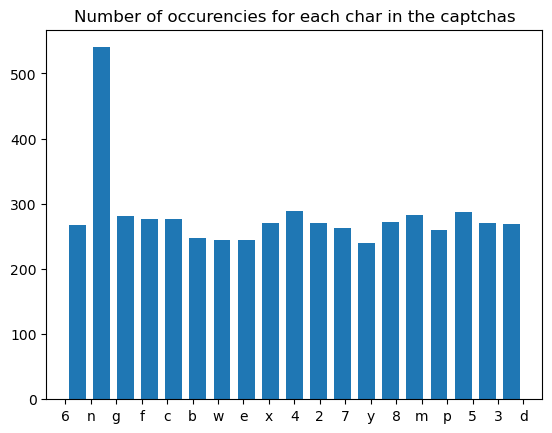

In [15]:
plt.hist(targets_flat, bins=len(set(targets_flat)), rwidth=0.7)
plt.title('Number of occurencies for each char in the captchas')

Что, если в новых данных будут буквы, которых нет в трейне

## Augmentations

In [16]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

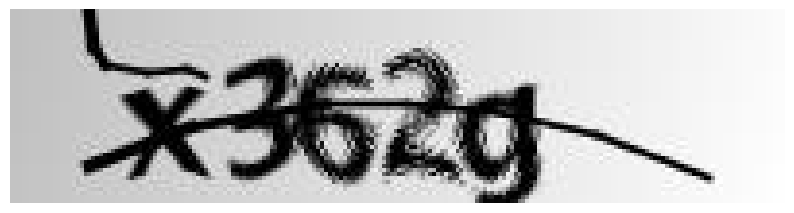

In [17]:
image = cv2.imread(path + 'x362g.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

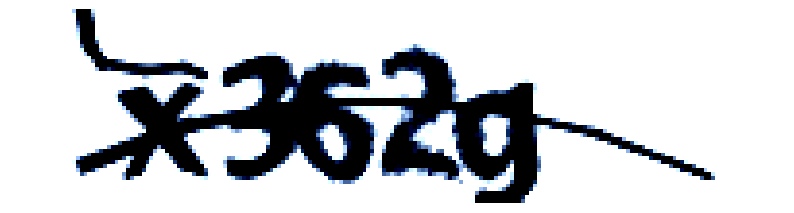

In [18]:
image = cv2.imread(path + 'x362g.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
size = (50, 200)

transform = A.Compose([
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
    A.Resize(*size),
    A.Normalize(mean=mean, std=std)
])

augmented_image = transform(image=image)['image']
visualize(augmented_image)

Выбранные аугментации не изменяют смысл задачи (буквы капч искревлены, картинки имеют разную насыщенность оттенка)

## Data preprocessing

In [19]:
class CaptchaDataset(Dataset):

    def __init__(self, dir_path, char_encoder):
        self.img_paths = list(Path(dir_path).glob("*.png")) + list(Path(dir_path).glob("*.jpg"))
        self.char_encoder = char_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = Image.open(img_path).convert('RGB') #convert('L')???????
        image = self.transform(image=image)['image']
        encoded_captcha = self.encode_chars(img_path.stem)
        return image, encoded_captcha
    
    def encode_chars(self, captcha):
        encoded_captcha = []
        for c in captcha:
            encoded_captcha.append(self.char_encoder[c])
        return encoded_captcha
         
    def transform(self, image):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        size = (50, 200)
        
        transform_ops = A.Compose([
            A.OpticalDistortion(),
            A.GridDistortion(),
            A.HueSaturationValue(),
            A.Resize(*size),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])
        return transform_ops(image=np.array(image))

## Train test split

In [20]:
dataset = CaptchaDataset(path, char_encoder)
batch_size = 32
validation_split = .25
shuffle_dataset = True
random_seed= 42

In [21]:
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
print(len(train_indices), len(val_indices))

803 267


In [22]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
print(len(train_loader), len(test_loader))

26 9


## Model

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Изображения капчи спроектированы таким образом, чтобы их было трудно прочитать машинам, и они часто содержат шум, искажения и накладывающиеся символы. CRNN может научиться извлекать значимые функции из изображения, используя сверточные слои, которые предназначены для обработки пространственных закономерностей во входном изображении. Выоход сверточных слоев затем может быть передан в рекуррентные слои, которые предназначены для обработки последовательных структур

Для решения задачи была выбрана архитектура как в статье https://arxiv.org/pdf/1507.05717.pdf + CTCloss:
CTC-loss позволяет обрабатывать маппинг many -> one (в отличие от кросс-энтропии - one -> one), поэтому можно было бы выбрать любой лосс (кол-во символов в капчах фиксировано), но CTC-loss может работать с символами разной ширины на изображениях. Гиперпараметры модели подобраны эмпирически

In [24]:
class BiLSTM(nn.Module):
    def __init__(self, inp, hidden, out, lstm=True):
        super(BiLSTM, self).__init__()
        self.rnn = nn.LSTM(inp, hidden, bidirectional=True)
        self.embedding = nn.Linear(hidden*2, out)
    def forward(self, X):
        output, _ = self.rnn(X)
        out = self.embedding(output)     
        return out
    
    
class CaptchaModel(nn.Module):
    def __init__(self, in_channels, output):
        super(CaptchaModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.maxpool1 = nn.MaxPool2d(3, 3)

        self.conv2 = nn.Conv2d(256, out_channels=512, kernel_size=2, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        
        self.linear = nn.Linear(8704, 256)
        self.rnn = BiLSTM(256, 1024, output+1)

    def forward(self, X, y=None):
        out = F.relu(self.conv1(X))
        out = self.bn1(out)
        out = self.maxpool1(out)
        
        out = F.relu(self.conv2(out))
        out = self.bn2(out)
        
        N, C, w, h = out.size()
        out = out.view(N, -1, h)
        out = out.permute(0, 2, 1)
        out = self.linear(out)

        out = out.permute(1, 0, 2)
        out = self.rnn(out)
            
        if y is not None:
            T = out.size(0)
            N = out.size(1)
        
            input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.int32)
            target_lengths = torch.full(size=(N,), fill_value=5, dtype=torch.int32)
        
            loss = nn.CTCLoss(blank=0)(out, y, input_lengths, target_lengths)
            
            return out, loss
        
        return out, None

    
model = CaptchaModel(in_channels=3, output=19).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Train and evaluation

In [25]:
def evaluate(model, dataloader):
    model.eval()
    running_loss = 0
    with tqdm(dataloader, total=len(dataloader)) as td:
        with torch.no_grad():
            for data, target in td:
                data = data.to(device=device)
                target = torch.stack(target, dim=1)
                target = target.to(device=device)

                out, loss = model(data, target)
                
                running_loss += loss.item()

                td.set_postfix(loss=loss.item())
                
    return running_loss / len(dataloader)

In [31]:
def train(epochs, model, optimizer, dataloader, scheduler):
    history_loss = []
    eval_losses = []
    for epoch in range(epochs):
        fin_loss = 0
        model.train()
        with tqdm(dataloader, unit="batch", total=len(dataloader)) as tepoch:
            for data, target in tepoch:
                
                tepoch.set_description(f"Epoch {epoch}")
                data = data.to(device=device)
                
                target = torch.stack(target, dim=1)
                target = target.to(device=device)

                optimizer.zero_grad()

                out, loss = model(data, target)

                loss.backward()

                optimizer.step()
            
                fin_loss += loss.item()

                tepoch.set_postfix(loss=loss.item())
            
        history_loss.append(fin_loss / len(dataloader))
        scheduler.step(fin_loss / len(dataloader))
        eval_loss = evaluate(model, dataloader)
        eval_losses.append(eval_loss)

    return history_loss, eval_losses

In [32]:
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')

In [33]:
epochs = 100
train_loss, eval_losses = train(epochs, model, optimizer, train_loader, scheduler)

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?batch/s]

  0%|          | 0/26 [00:00<?, ?it/s]

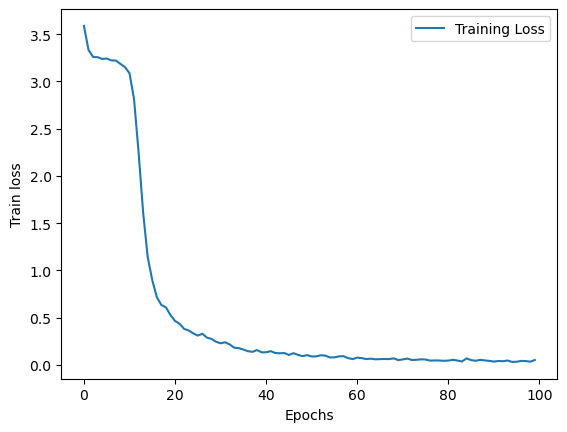

In [34]:
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Train loss')
plt.legend(loc='best')
plt.show()

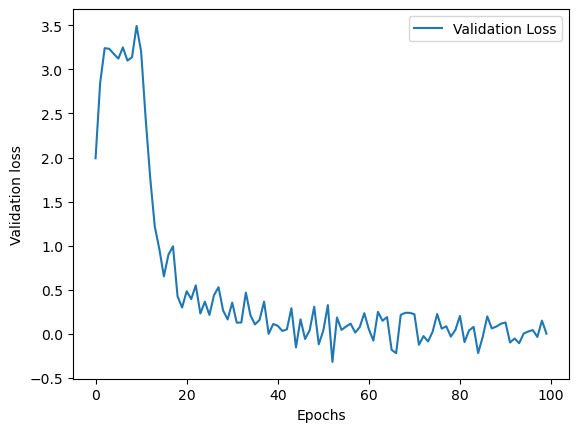

In [35]:
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend(loc='best')
plt.show()

In [36]:
def transform(image):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    transform_ops = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    return transform_ops(image)

In [37]:
def predict(path_image):
    image = Image.open(path_image).convert('RGB')
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)  
    out, _ = model(image_tensor.to(device=device))
    out = out.permute(1, 0, 2)
    out = out.log_softmax(2)
    out = out.argmax(2)
    out = out.cpu().detach().numpy()

    return out

## Metrics

In [38]:
test_images = []
test_labels = []
for i in val_indices:
    test_images.append(dataset.img_paths[i].name)
    test_labels.append(dataset.img_paths[i].stem)

In [43]:
from evaluate import load

cer = load("cer")
accum_cer = []
preds = []
for image_path, label in zip(test_images, test_labels):
    out = predict(path + image_path)[0]
    
    pred = ''
    then = 0
    for x in out:
        if then != x:
            if x > 0 :
                pred += char_encoder_reversed[x]
        then = x
    preds.append(pred)

In [44]:
cer_score = cer.compute(predictions=preds, references=test_labels)
print(f"Average CER: {cer_score}")

Average CER: 0.0022471910112359553


In [45]:
accum_cer = []
for pred, label in zip(preds, test_labels):
    cer_score = cer.compute(predictions=[pred], references=[label])
    accum_cer.append(cer_score)

In [46]:
idx = np.where(accum_cer)[0]
idx

array([ 35, 131, 247])

### В табличке ниже выборка сэмплов, на которых модель ошибается

In [47]:
import pandas as pd

df = pd.DataFrame(list(zip([test_labels[i] for i in idx], [preds[i] for i in idx])), 
                  columns = ['Test label', 'Pred'])
df['CER'] = np.array([accum_cer[i] for i in idx])
df

,Test label,Pred,CER
0,mxnw4,mxmw4,0.2
1,cx3wg,x3wg,0.2
2,37d52,7d52,0.2


## Возможные причины ошибок

1. Недостаточное количество обучающих данных: модель может быть не в состоянии уловить всю сложность изображений капчи, что приведет к низкой точности

2. Низкое качество обучающих данных

3. Возможно необходима дополнительная предварительная обработка изображений

## Выводы

Видно, что модель спутала m и n (скорее всего т к буквы похожи) 

Получившееся значение метрики говорит о том, что модель хорошо обучилась. Однако можно улчшить результаты:

1. Увеличить размер набора обучающих данных: добавление дополнительных примеров может помочь модели лучше обобщать тестовые данные.

2. Дополнительные аугментации: можно попробовать другие способы разнообразить датасет

3. Настройка гиперпараметров модели: можно потюнить learning rate, batch size, количество эпох и архитектуру сети, чтобы найти наилучшую комбинацию 

4. Использование предварительно обученной модели (например, ResNet) в качестве экстрактора признаков + меньшая модель CRNN поверх нее

5. Ансамбль моделей: можно обучить несколько моделей CRNN с различными гиперпараметрами и архитектурами, а затем комбинировать их прогнозы, используя схему голосования или усреднения, чтобы улучшить общую производительность

6. Использование другой функции потерь: например, можно использовать кросс-энтропию